In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your dataset
df= pd.read_csv("../data/dataset.csv")
df=df[df['property_type']=='HOUSE']

df.shape

/var/folders/db/gqzpbl8d1vxgl2x39wd0j1cw0000gp/T/ipykernel_69587/1973227439.py:13: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("data/cleaned_data_withextrainfo.csv")


(9037, 35)

In [83]:
df.columns

Index(['house_index', 'bedrooms', 'bathrooms', 'toilets', 'property_type',
       'property_subtype', 'locality', 'postal_code', 'street', 'number',
       'box', 'apptFloor', 'totalfloorCount', 'latitude', 'longitude',
       'kitchen', 'facades', 'furnished', 'terrace', 'terraceSurface',
       'fireplace', 'fireplaceCount', 'garden', 'gardenSurface', 'pool',
       'landSurface', 'livingArea', 'buildingState', 'constructionYear',
       'cadastralIncome', 'price', 'nearest_transport', 'nearest_school',
       'nearest_supermarket', 'mobib_score'],
      dtype='object')

In [84]:
# df_featured=df[['locality','bedrooms', 'bathrooms','livingArea','cadastralIncome','buildingState','toilets','facades','pool','price']]
df_featured=df[['mobib_score','locality','cadastralIncome','constructionYear','facades','livingArea','bedrooms', 'bathrooms','buildingState','fireplace','toilets','gardenSurface','landSurface','price']]
df_featured.shape

(9037, 14)

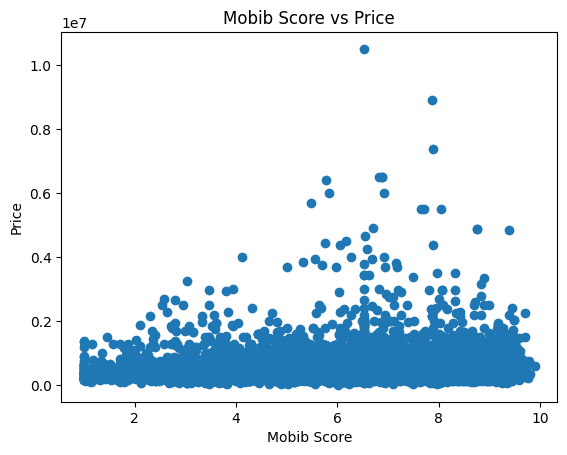

In [85]:
import matplotlib.pyplot as plt
plt.scatter(df_featured['mobib_score'], df_featured['price'])
plt.xlabel('Mobib Score')
plt.ylabel('Price')
plt.title('Mobib Score vs Price')
plt.show()


In [86]:


df_featured['bedrooms'] = df_featured['bedrooms'].fillna(df_featured['bedrooms'].mode())
df_featured['bathrooms'] = df_featured['bathrooms'].fillna(df_featured['bathrooms'].mode())
df_featured['toilets'] = df_featured['toilets'].fillna(1)
df_featured['livingArea'] = df_featured['livingArea'].fillna(df_featured['livingArea'].mean())
df_featured['cadastralIncome'] = df_featured['cadastralIncome'].fillna(df_featured['cadastralIncome'].mean())
df_featured['facades'] = df_featured['facades'].fillna(2)
#df_featured['pool'] = df_featured['pool'].fillna(0)
df_featured['fireplace'] = df_featured['fireplace'].fillna(1)
df_featured['gardenSurface'] = df_featured['gardenSurface'].fillna(df_featured['gardenSurface'].mean())
df_featured['landSurface'] = df_featured['landSurface'].fillna(df_featured['landSurface'].mean())
building_state_mapping = {
    'AS_NEW': 6,
    'JUST_RENOVATED': 5,
    'GOOD': 4,
    'TO_BE_DONE_UP': 3,
    'TO_RENOVATE':2,
    'TO_RESTORE':1
}
df_featured['buildingState'] = df_featured['buildingState'].map(building_state_mapping)
# Drop rows with NaN values
df_featured = df_featured.dropna()
df_featured = df_featured.dropna(subset=['price'])
#df_featured.isnull().sum()
df_featured.shape


/var/folders/db/gqzpbl8d1vxgl2x39wd0j1cw0000gp/T/ipykernel_69587/244097723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_featured['bedrooms'] = df_featured['bedrooms'].fillna(df_featured['bedrooms'].mode())
/var/folders/db/gqzpbl8d1vxgl2x39wd0j1cw0000gp/T/ipykernel_69587/244097723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_featured['bathrooms'] = df_featured['bathrooms'].fillna(df_featured['bathrooms'].mode())
/var/folders/db/gqzpbl8d1vxgl2x39wd0j1cw0000gp/T/ipykernel_69587/244097723.py

(7288, 14)

In [87]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_without_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    #print(f'{len(df)-len(df_without_outliers)} rows have been removed from the {column} column')
    return df_without_outliers


#handling the outliers
df_featured=remove_outliers(df_featured, 'price')
df_featured=remove_outliers(df_featured, 'livingArea')
df_featured=remove_outliers(df_featured, 'gardenSurface')
df_featured=remove_outliers(df_featured, 'landSurface')
df_featured=remove_outliers(df_featured, 'bathrooms')
df_featured=remove_outliers(df_featured, 'bedrooms')
df_featured=remove_outliers(df_featured, 'facades')
df_featured=remove_outliers(df_featured, 'toilets')
#df_featured=remove_outliers(df_featured, 'pool')
df_featured=remove_outliers(df_featured,'cadastralIncome')


df_featured.shape
df_featured.isnull().sum()

mobib_score         0
locality            0
cadastralIncome     0
constructionYear    0
facades             0
livingArea          0
bedrooms            0
bathrooms           0
buildingState       0
fireplace           0
toilets             0
gardenSurface       0
landSurface         0
price               0
dtype: int64

In [88]:
# Split the dataset

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
import category_encoders as ce
import xgboost as xgb


train_data, test_data = train_test_split(df_featured, test_size=0.2, random_state=42)

# Fit TargetEncoder on the training set
encoder = ce.TargetEncoder(cols=['locality'],smoothing=5)
train_data['locality'] = encoder.fit_transform(train_data['locality'], train_data['price'])

test_data['locality'] = encoder.transform(test_data['locality'])

# Separate features (X) and target (y) for the training and test sets
X_train = train_data.drop(columns=['price'])  # Drop the target column
y_train = train_data['price']                # Target variable

X_test = test_data.drop(columns=['price'])   # Drop the target column
y_test = test_data['price']     
original_feature_names=X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

num=X_train.shape[1]
pca = PCA(n_components=num)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

feature_names = poly.get_feature_names_out(original_feature_names)

model=ElasticNet(alpha=200, l1_ratio=1.0)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
rmse = np.sqrt(mse)
print(f"rmse: {rmse}")
print(f"R² Score: {r2}")             # Target variable

# Verify the shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



Mean Absolute Error: 103914.82173476045
Mean Squared Error: 28388226129.829994
rmse: 168488.0593093469
R² Score: 0.6623413031947685
X_train shape: (5569, 104)
y_train shape: (5569,)
X_test shape: (1393, 104)
y_test shape: (1393,)


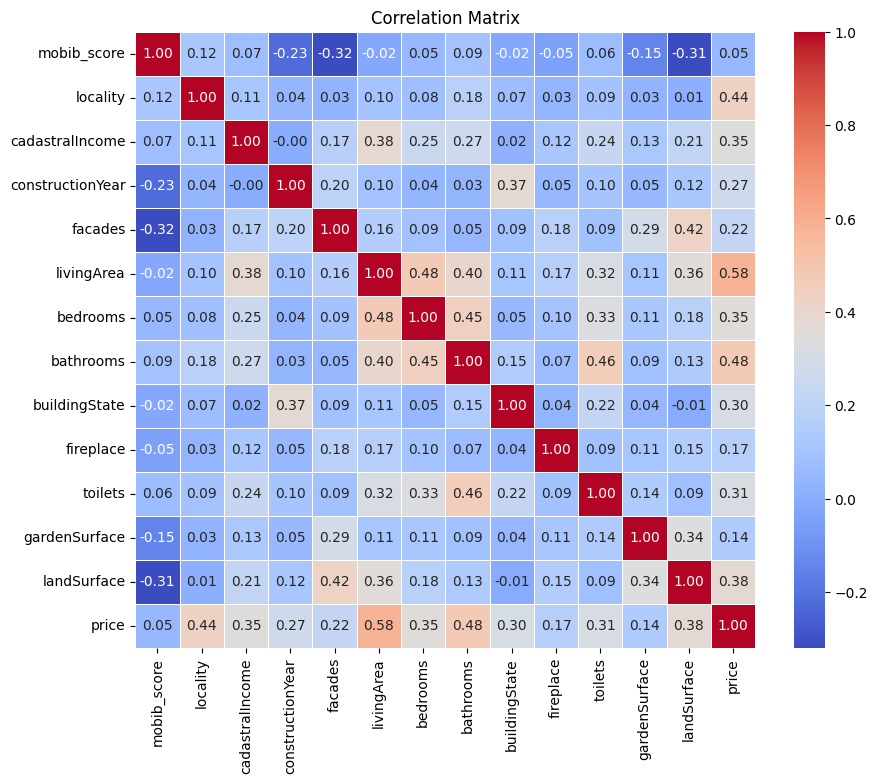

In [89]:
correlation_matrix = train_data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

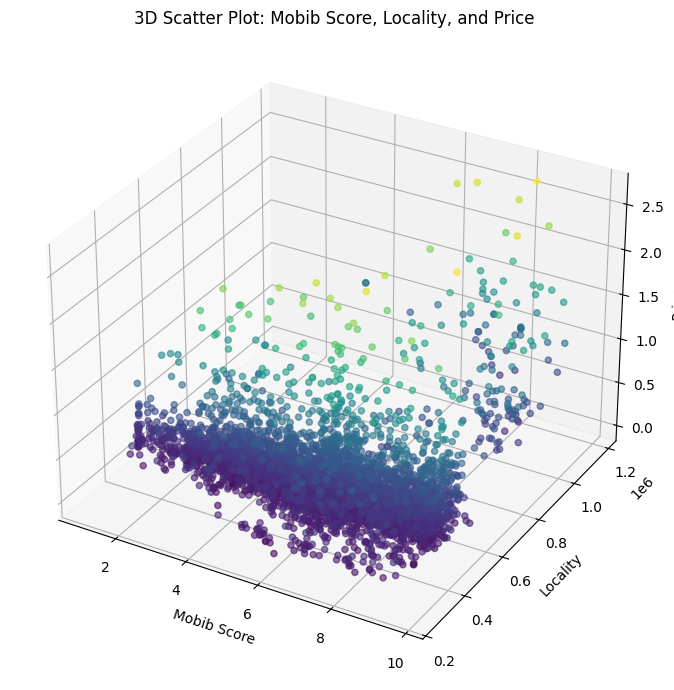

In [90]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(
    train_data['mobib_score'], 
    train_data['locality'],
    train_data['price'], 
    c=train_data['price'], cmap='viridis', alpha=0.6
)

ax.set_xlabel('Mobib Score')
ax.set_ylabel('Locality')
ax.set_zlabel('Price')
ax.set_title('3D Scatter Plot: Mobib Score, Locality, and Price')
plt.tight_layout()
plt.show()

In [95]:
coefficients = model.coef_

#Create a DataFrame for ranking
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Display the ranking
print(coeff_df.head(10))

                 Feature    Coefficient     Importance
0            mobib_score  105621.690800  105621.690800
3       constructionYear   74273.910406   74273.910406
5             livingArea  -69699.145665   69699.145665
9              fireplace  -57833.099197   57833.099197
10               toilets   43804.258791   43804.258791
7              bathrooms  -38734.021011   38734.021011
2        cadastralIncome   34477.228139   34477.228139
8          buildingState   24332.491404   24332.491404
1               locality   23285.201880   23285.201880
37  locality landSurface  -21853.503618   21853.503618


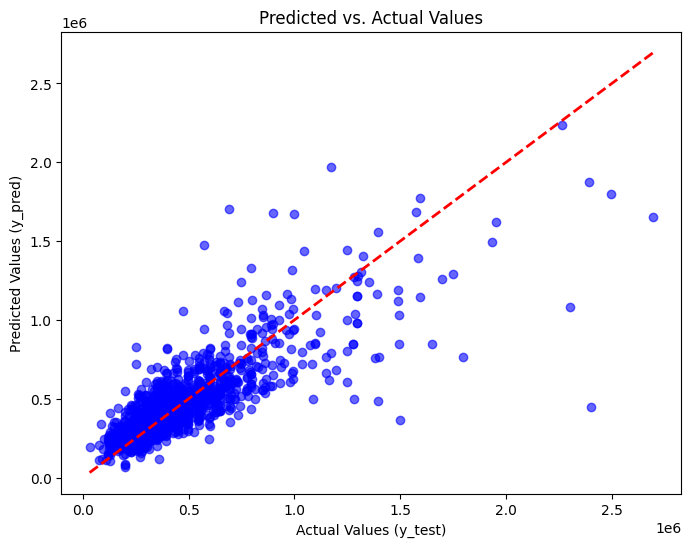

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)  # Perfect prediction line
plt.title("Predicted vs. Actual Values")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.show()


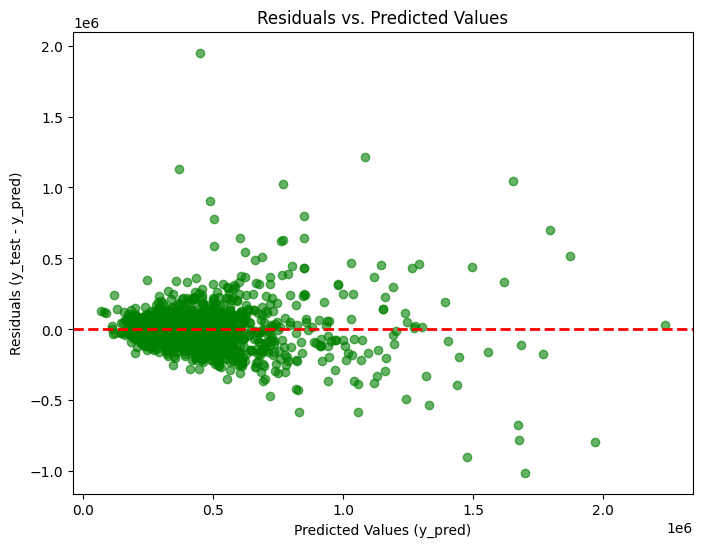

In [93]:
# Residual plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values (y_pred)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.show()


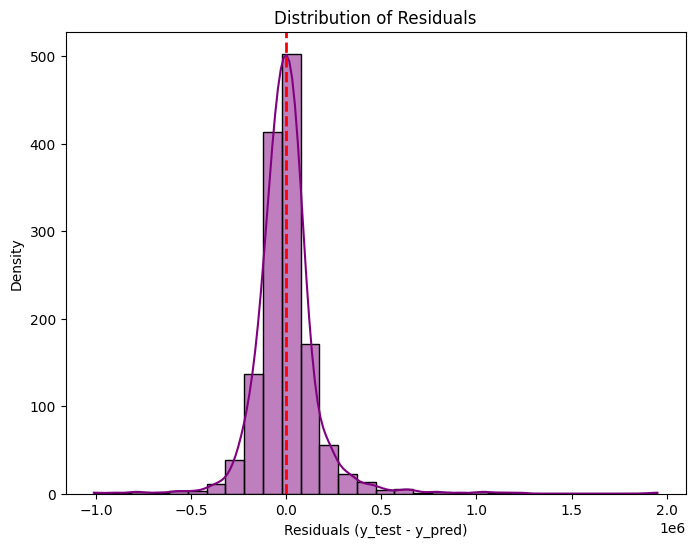

In [94]:
#Density Plot of Residuals
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (y_test - y_pred)")
plt.ylabel("Density")
plt.show()
